reference: https://redis.io/learn/howtos/solutions/vector/getting-started-vector

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from transformers import pipeline
from sentence_transformers import SentenceTransformer

import timm
import torch
import os
import json
import numpy as np

import urllib
from PIL import Image
from timm.data import resolve_data_config
from timm.data.transforms_factory import create_transform

from sklearn.metrics.pairwise import cosine_similarity

c:\Users\meshams.REDMOND\AppData\Local\anaconda3\envs\deeplearning\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Word2Vec

https://en.wikipedia.org/wiki/Word2vec

Paper:
https://arxiv.org/abs/1310.4546

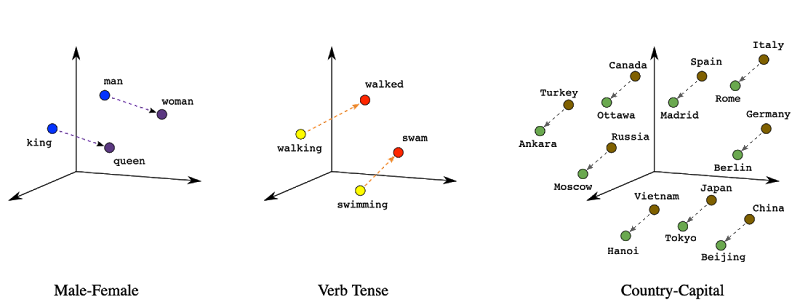

### Sentence Embedding

In [3]:
def generate_sentence_embeddings(sentences):
    model = SentenceTransformer('sentence-transformers/all-distilroberta-v1')
    embeddings = model.encode(sentences).astype(np.float32)
    return embeddings

In [5]:
sentences = ["I love embeddings!"]

embeddings = generate_sentence_embeddings(sentences)
print(embeddings)

[[ 1.32160839e-02  2.31917467e-04 -8.94454308e-03 -5.03668338e-02
   2.79321335e-02 -2.08608657e-02 -3.34585011e-02  3.36709879e-02
  -5.39664589e-02 -3.53584401e-02 -2.81051900e-02  1.23227350e-02
  -4.13644277e-02 -4.42235842e-02 -1.15368450e-02  6.62368461e-02
   1.99055895e-02 -5.56174479e-02  1.11052592e-03 -1.40633788e-02
   9.43071768e-03  3.07515953e-02  2.15665083e-02 -4.77008820e-02
  -5.02071343e-02 -4.11845651e-03  3.25617231e-02 -5.20540820e-03
  -3.12205087e-02 -8.55839066e-03  1.31419925e-02  3.94911394e-02
  -1.37325674e-02  3.67497280e-02 -1.96955279e-02  2.80400496e-02
   4.34746556e-02 -1.17708603e-02  2.32370314e-03  1.22128148e-03
  -2.50814687e-02  5.17522693e-02 -4.65617180e-02  1.75152766e-03
   3.69402394e-02  1.31797483e-02 -4.46319580e-02 -9.81248543e-02
   1.69810448e-02  3.06888875e-02 -2.00023819e-02  3.09656821e-02
  -3.32045555e-02 -1.11954734e-02  5.45033999e-03  5.94260208e-02
   3.70874914e-04  2.51979847e-02  5.28231077e-02  1.46798836e-02
  -5.71625

In [6]:
embeddings.shape
TEXT_VECTOR_DIM = embeddings.shape[-1]

### Image Embedding

In [7]:
image_file_name = 'dog.jpg'

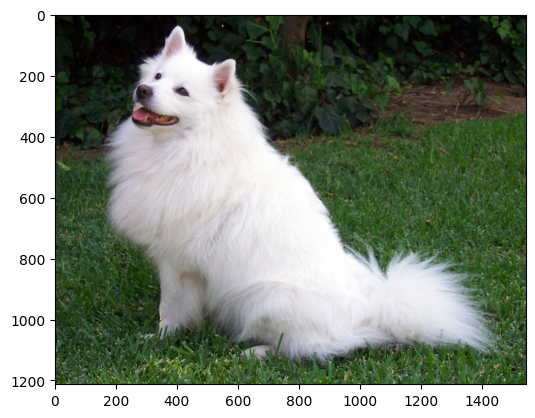

In [8]:
img = Image.open(image_file_name).convert('RGB')
plt.imshow(img)

In [9]:
model = timm.create_model('mobilenetv3_large_100', pretrained=True)
model.eval()

c:\Users\meshams.REDMOND\AppData\Local\anaconda3\envs\deeplearning\Lib\site-packages\huggingface_hub\file_download.py:159: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\meshams.REDMOND\.cache\huggingface\hub\models--timm--mobilenetv3_large_100.ra_in1k. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


MobileNetV3(
  (conv_stem): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (bn1): BatchNormAct2d(
    16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
    (drop): Identity()
    (act): Hardswish()
  )
  (blocks): Sequential(
    (0): Sequential(
      (0): DepthwiseSeparableConv(
        (conv_dw): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
        (bn1): BatchNormAct2d(
          16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
          (drop): Identity()
          (act): ReLU(inplace=True)
        )
        (aa): Identity()
        (se): Identity()
        (conv_pw): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn2): BatchNormAct2d(
          16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
          (drop): Identity()
          (act): Identity()
        )
        (drop_path): Identity()
      )
    )
    (1): Sequential(
     

In [10]:
def decode_image_to_tensor(model, filename):
    # url, filename = ("https://github.com/pytorch/hub/raw/master/images/dog.jpg", "dog.jpg")
    # urllib.request.urlretrieve(url, filename)
    img = Image.open(filename).convert('RGB')

    config = resolve_data_config({}, model=model)
    transform = create_transform(**config)

    tensor = transform(img).unsqueeze(0) # transform and add batch dimension
    return tensor

In [11]:
def classify_image(model, filename):
    tensor = decode_image_to_tensor(model, filename)
    with torch.no_grad():
        out = model(tensor)
    probabilities = torch.nn.functional.softmax(out[0], dim=0)

    image_net_classes = "imagenet_classes.txt"

    # Get imagenet class mappings
    if not os.path.exists(image_net_classes):
        url, filename = ("https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt", image_net_classes)
        urllib.request.urlretrieve(url, filename)

    with open(image_net_classes, "r") as f:
        categories = [s.strip() for s in f.readlines()]

    # Print top categories per image
    top5_prob, top5_catid = torch.topk(probabilities, 5)
    for i in range(top5_prob.size(0)):
        print(categories[top5_catid[i]], top5_prob[i].item())
    # prints class names and probabilities like:
    # [('Samoyed', 0.6425196528434753), ('Pomeranian', 0.04062102362513542), ('keeshond', 0.03186424449086189), ('white wolf', 0.01739676296710968), ('Eskimo dog', 0.011717947199940681)]


In [12]:
classify_image(model, image_file_name)

Samoyed 0.8104052543640137
white wolf 0.0218444112688303
Eskimo dog 0.01768295094370842
Arctic fox 0.0092905443161726
wallaby 0.007410981692373753


In [13]:
def generate_image_embeddings(model, image):
    tensor = decode_image_to_tensor(model, image)
    model.reset_classifier(0)
    with torch.no_grad():
        out = model(tensor)
    return out[0].numpy()

In [14]:
embeddings = generate_image_embeddings(model, image_file_name)


In [15]:
embeddings
embeddings.shape
IMAGE_VECTOR_DIM = embeddings.shape[0]

### ElasticSearch Vector Support

In [76]:
with open('products.json', 'r') as f:
    products = json.load(f)

In [77]:
products

[{'_id': '1',
  'price': 4950,
  'productDisplayName': 'Puma Men Race Black Watch',
  'brandName': 'Puma',
  'ageGroup': 'Adults-Men',
  'gender': 'Men',
  'masterCategory': 'Accessories',
  'subCategory': 'Watches',
  'imageURL': 'images/11002.jpg',
  'productDescription': '<p>This watch from puma comes in a heavy duty design. The asymmetric dial and chunky casing gives this watch a tough appearance perfect for navigating the urban jungle.<br /><strong><br />Dial shape</strong>: Round<br /><strong>Case diameter</strong>: 32 cm<br /><strong>Warranty</strong>: 2 Years<br /><br />Stainless steel case with a fixed bezel for added durability, style and comfort<br />Leather straps with a tang clasp for comfort and style<br />Black dial with cat logo on the 12 hour mark<br />Date aperture at the 3 hour mark<br />Analog time display<br />Solid case back made of stainless steel for enhanced durability<br />Water resistant upto 100 metres</p>'},
 {'_id': '2',
  'price': 5450,
  'productDisplayN

In [78]:
for product in products:
    product_id = product['_id']
    product_desc = product['productDescription']
    product_image = product['imageURL']

    print(f'generating description embeddings for product {product_id}')

    sentence_embedding = generate_sentence_embeddings([product_desc])
    product['productDescriptionEmbeddings'] = sentence_embedding[0].tolist()

    print(f'generating image embeddings for product {product_id}')
    image_embedding = generate_image_embeddings(model, product_image)
    product['productImageEmbeddings'] = image_embedding.tolist()

generating description embeddings for product 1
generating image embeddings for product 1
generating description embeddings for product 2
generating image embeddings for product 2
generating description embeddings for product 3
generating image embeddings for product 3
generating description embeddings for product 4
generating image embeddings for product 4


In [18]:
!pip install -qU elasticsearch

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [79]:
# import modules
import pandas as pd, json
from elasticsearch import Elasticsearch
from elasticsearch.helpers import bulk
from getpass import getpass
from urllib.request import urlopen
from pprint import pprint
from IPython.display import display, HTML
import os

In [43]:
ELASTIC_PASSWORD = os.environ.get('ELASTIC_PASSWORD') or getpass('Enter your elasticsearch password: ')

In [44]:
es = Elasticsearch(
    ['https://elastic:{}'.format(ELASTIC_PASSWORD) + '@localhost:9200'],
    verify_certs=False,
    ca_certs='../http_ca.crt'
)
es.info()

c:\Users\meshams.REDMOND\AppData\Local\anaconda3\envs\deeplearning\Lib\site-packages\elasticsearch\_sync\client\__init__.py:400: SecurityWarning: Connecting to 'https://localhost:9200' using TLS with verify_certs=False is insecure
  _transport = transport_class(
c:\Users\meshams.REDMOND\AppData\Local\anaconda3\envs\deeplearning\Lib\site-packages\urllib3\connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'localhost'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


ObjectApiResponse({'name': 'f01be19914b1', 'cluster_name': 'docker-cluster', 'cluster_uuid': '5o77ktHwQCq2iymrrUExsw', 'version': {'number': '8.15.0', 'build_flavor': 'default', 'build_type': 'docker', 'build_hash': '1a77947f34deddb41af25e6f0ddb8e830159c179', 'build_date': '2024-08-05T10:05:34.233336849Z', 'build_snapshot': False, 'lucene_version': '9.11.1', 'minimum_wire_compatibility_version': '7.17.0', 'minimum_index_compatibility_version': '7.0.0'}, 'tagline': 'You Know, for Search'})

In [47]:
INDEX_NAME = "product_index"

In [80]:
# Define the mapping
mappings = {
    "properties": {
        "title_vector": {
            "type": "dense_vector",
            "dims": TEXT_VECTOR_DIM,
            "index": "true",
            "similarity": "cosine",
        },
        "image_vector": {
            "type": "dense_vector",
            "dims": IMAGE_VECTOR_DIM,
            "index": "true",
            "similarity": "cosine",
        }
    }
}

es.indices.delete(index=INDEX_NAME, ignore_unavailable=True)
# Create the index
es.indices.create(index=INDEX_NAME, mappings=mappings)


c:\Users\meshams.REDMOND\AppData\Local\anaconda3\envs\deeplearning\Lib\site-packages\urllib3\connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'localhost'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
c:\Users\meshams.REDMOND\AppData\Local\anaconda3\envs\deeplearning\Lib\site-packages\urllib3\connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'localhost'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


ObjectApiResponse({'acknowledged': True, 'shards_acknowledged': True, 'index': 'product_index'})

In [81]:
operations = []
for product in products:
    product_id = product['_id']
    product_desc = product['productDescription']
    product_image = product['imageURL']
    product_desc_embedding = product['productDescriptionEmbeddings']
    product_image_embedding = product['productImageEmbeddings']

    # Create the document
    doc = {
        "product_id": product_id,
        "title": product_desc,        
        "title_vector": product_desc_embedding,
        "image_url": product_image,
        "image_vector": product_image_embedding,
    }

    operations.append({"index": {"_index": INDEX_NAME}})

    # Add the document to the list of all operations
    operations.append(doc)

es.bulk(index=INDEX_NAME, operations=operations, refresh=True)

c:\Users\meshams.REDMOND\AppData\Local\anaconda3\envs\deeplearning\Lib\site-packages\urllib3\connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'localhost'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


ObjectApiResponse({'errors': False, 'took': 1141116685, 'items': [{'index': {'_index': 'product_index', '_id': 'OoTDlZEBcIYFM6UzpZgw', '_version': 1, 'result': 'created', 'forced_refresh': True, '_shards': {'total': 2, 'successful': 1, 'failed': 0}, '_seq_no': 0, '_primary_term': 1, 'status': 201}}, {'index': {'_index': 'product_index', '_id': 'O4TDlZEBcIYFM6UzpZgw', '_version': 1, 'result': 'created', 'forced_refresh': True, '_shards': {'total': 2, 'successful': 1, 'failed': 0}, '_seq_no': 1, '_primary_term': 1, 'status': 201}}, {'index': {'_index': 'product_index', '_id': 'PITDlZEBcIYFM6UzpZgw', '_version': 1, 'result': 'created', 'forced_refresh': True, '_shards': {'total': 2, 'successful': 1, 'failed': 0}, '_seq_no': 2, '_primary_term': 1, 'status': 201}}, {'index': {'_index': 'product_index', '_id': 'PYTDlZEBcIYFM6UzpZgw', '_version': 1, 'result': 'created', 'forced_refresh': True, '_shards': {'total': 2, 'successful': 1, 'failed': 0}, '_seq_no': 3, '_primary_term': 1, 'status': 2

In [82]:
def pretty_response(response):
    pretty_output = ''
    if len(response["hits"]["hits"]) == 0:
        print("Your search returned no results.")
    else:
        for hit in response["hits"]["hits"]:
            id = hit["_id"]
            product_id = hit["_source"]["product_id"]
            score = hit["_score"]
            title = hit["_source"]["title"]
            img_url = hit["_source"]["image_url"]
            pretty_output += f"""
            <div>
                ID: {id}\n
                ProductId: {product_id}\n
                Title: {title}
                Score: <b>{score}</b>
                
                <br/>
                <img src="{img_url}" width="100" height="100">
            </div>
            <hr/>
            """            
    
    display(HTML(pretty_output))

### Text Search

In [83]:
def search_for_text(text_vector):
    return es.search(
        index=INDEX_NAME,
        knn={
            "field": "title_vector",
            "query_vector": text_vector,
            "k": 10,
            "num_candidates": 100,
        },
    )

In [84]:
search_text = "Puma watch with cat"
search_text_emb = generate_sentence_embeddings([search_text])[0].tolist()

response = search_for_text(search_text_emb)

pretty_response(response.body)

c:\Users\meshams.REDMOND\AppData\Local\anaconda3\envs\deeplearning\Lib\site-packages\urllib3\connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'localhost'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


### Image Search

In [66]:
def search_for_image(img_vector):
    return es.search(
        index=INDEX_NAME,
        knn={
            "field": "image_vector",
            "query_vector": img_vector,
            "k": 10,
            "num_candidates": 100,
        },
    )

In [64]:
watch_emb = generate_image_embeddings(model, 'images/11008.jpg').tolist()

In [69]:
response = search_for_image(watch_emb)

pretty_response(response.body)

c:\Users\meshams.REDMOND\AppData\Local\anaconda3\envs\deeplearning\Lib\site-packages\urllib3\connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'localhost'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


In [70]:
dog_emb = generate_image_embeddings(model, 'dog.jpg')
dog2_emb = generate_image_embeddings(model, 'dog2.jpg')

In [71]:
response = search_for_image(dog_emb)

pretty_response(response.body)

c:\Users\meshams.REDMOND\AppData\Local\anaconda3\envs\deeplearning\Lib\site-packages\urllib3\connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'localhost'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


In [72]:
cosine_similarity([dog_emb], [watch_emb])

array([[-0.07149736]])

In [73]:
cosine_similarity([dog_emb], [dog2_emb])

array([[0.27295554]], dtype=float32)

# GPT

"Attention Is All You Need"

https://arxiv.org/abs/1706.03762


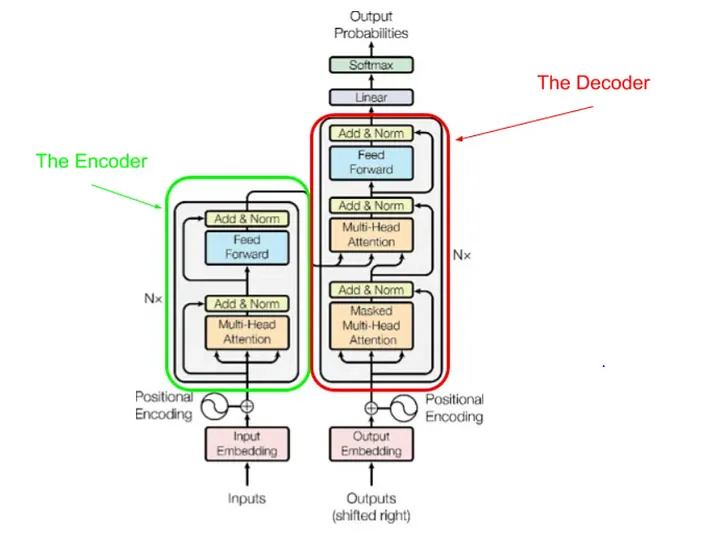

https://karpathy.ai/zero-to-hero.html

